In [1]:
import sys
sys.path.insert(0,'../code')

In [2]:
import torch
import matplotlib.pyplot as plt

from datamodules.image_classification import CIFAR10DataModule
from transformers import ViTFeatureExtractor, ViTForImageClassification
from models.interpretation import ImageInterpretationNet
from attributions.grad_cam import grad_cam
from attributions.attention_rollout import attention_rollout
from attributions.chefer import chefer_attributions
from utils.plot import smoothen, draw_mask_on_image, draw_heatmap_on_image, unnormalize
from datamodules.transformations import UnNest
import cv2

/home/angelos/anaconda3/envs/dl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load images and model

In [3]:
# vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10")
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

diffmask_cifar = ImageInterpretationNet.load_from_checkpoint('../checkpoints/diffmask.ckpt')
diffmask_cifar.set_vision_transformer(vit)

diffmask_imagenet = ImageInterpretationNet.load_from_checkpoint('../checkpoints/6.ckpt')
diffmask_imagenet.set_vision_transformer(vit)

# feature_extractor=ViTFeatureExtractor.from_pretrained(
#     "tanlq/vit-base-patch16-224-in21k-finetuned-cifar10", return_tensors="pt"
# )

feature_extractor=ViTFeatureExtractor.from_pretrained(
    "google/vit-base-patch16-224", return_tensors="pt"
)
feature_extractor = UnNest(feature_extractor)

In [4]:
num_images = 13
images = []
for i in range(num_images):
    img = cv2.imread(f'imagenet/{i+1}.jpeg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.tensor(img).permute(2,0,1)
    img = feature_extractor(img)    
    images.append(img)
    
images = torch.stack(images)
labels = diffmask_imagenet(images).softmax(-1).argmax(-1)

print([vit.config.id2label[label.item()] for label in labels])

images.requires_grad = True

rgb_images = [img.permute(1, 2, 0) for img in unnormalize(images)]  


['ostrich, Struthio camelus', 'bullfrog, Rana catesbeiana', 'Brittany spaniel', 'Chihuahua', 'Welsh springer spaniel', 'sombrero', 'Indian cobra, Naja naja', 'Chihuahua', 'comic book', 'soccer ball', 'jaguar, panther, Panthera onca, Felis onca', 'Boston bull, Boston terrier', 'tractor']


In [5]:
gradcam_masks = grad_cam(images, vit)

chefer_masks = [chefer_attributions(vit, img) for img in images]

X_attention_rollout = images.clone()
B, C, H, W = X_attention_rollout.shape
X_attention_rollout = torch.cat([torch.zeros(1, C, H, W), X_attention_rollout], dim=0)
rollout_masks = attention_rollout(X_attention_rollout, vit=vit)
rollout_masks = rollout_masks[1:]


masks_cifar = diffmask_cifar.get_mask(images)["mask"].detach()
masks_imagenet = diffmask_imagenet.get_mask(images)["mask"].detach()

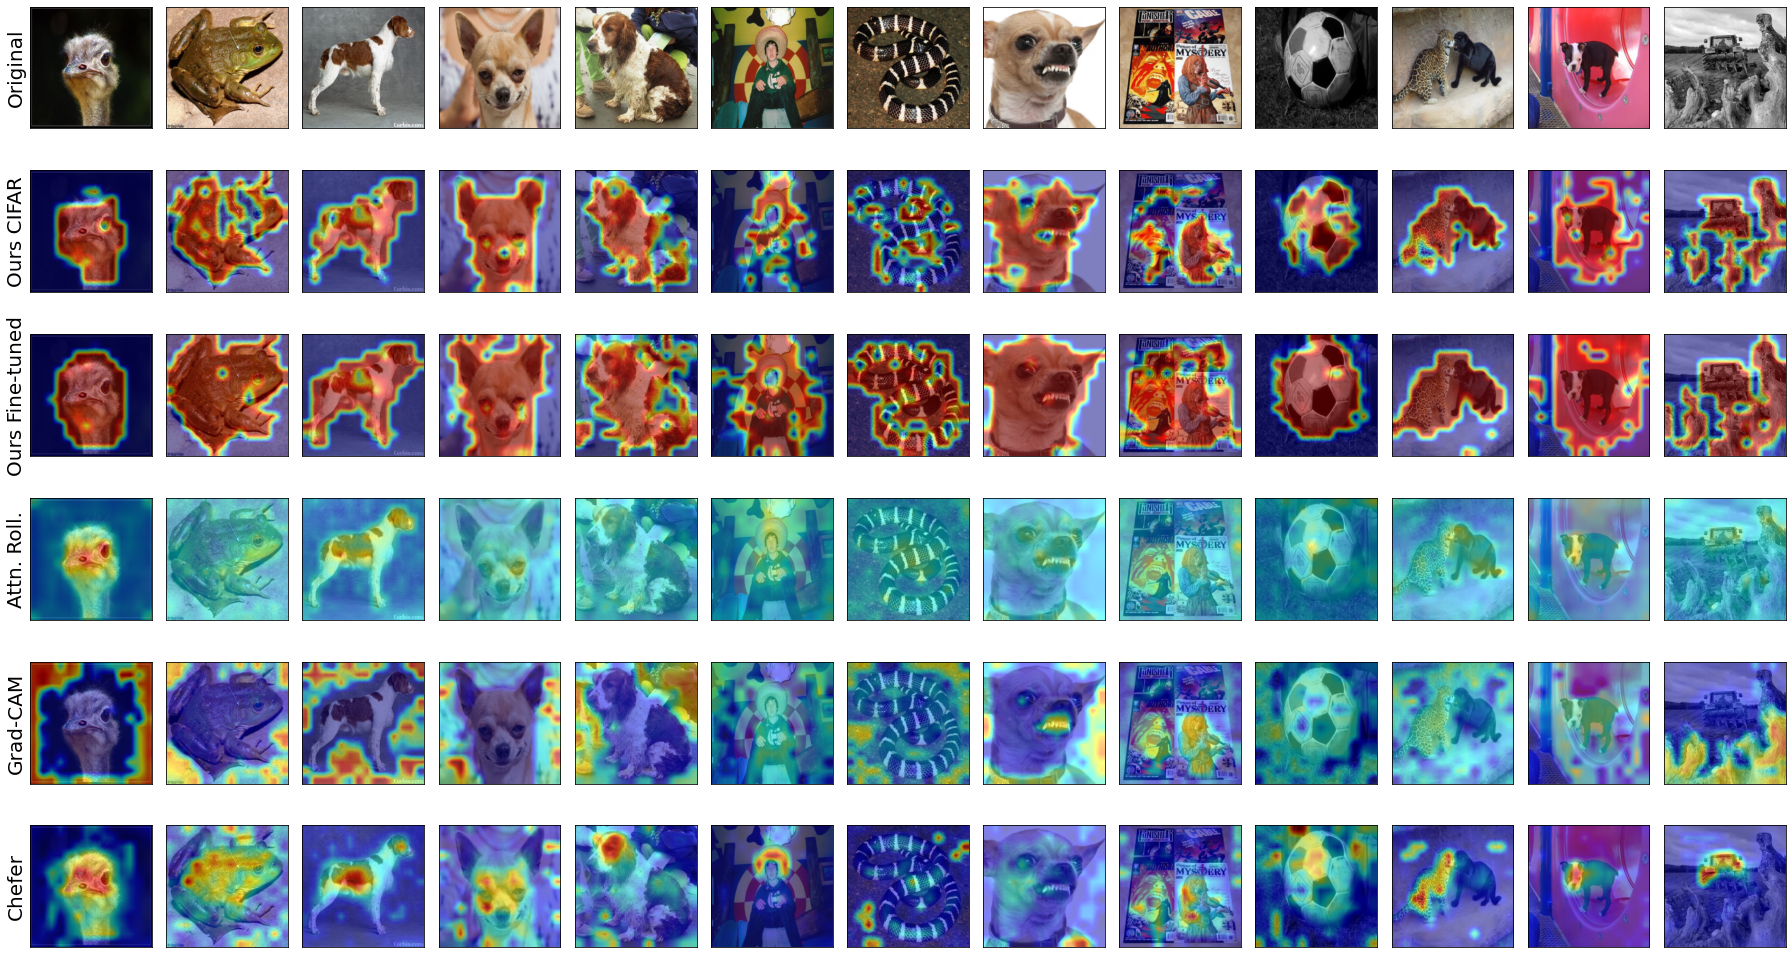

In [6]:
draw_mask = lambda image, mask: draw_mask_on_image(image.permute(2, 0, 1), mask).permute(1, 2, 0).clip(0, 1).numpy()
draw_heatmap = lambda image, mask: draw_heatmap_on_image(image.permute(2, 0, 1), mask).permute(1, 2, 0).clip(0, 1).numpy()

fig, ax = plt.subplots(6, 13, figsize=(25, 14))

# Remove axes
for i in range(6):
    for j in range(13):
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

font_size = 20
for i in range(13):
    # Original image
    if i == 0:
        ax[0, i].set_ylabel("Original", fontsize=font_size)
        ax[1, i].set_ylabel("Ours CIFAR", fontsize=font_size)
        ax[2, i].set_ylabel("Ours Fine-tuned", fontsize=font_size)
        ax[3, i].set_ylabel("Attn. Roll.", fontsize=font_size)
        ax[4, i].set_ylabel("Grad-CAM", fontsize=font_size)
        ax[5, i].set_ylabel("Chefer", fontsize=font_size)

        
    ax[0, i].imshow(rgb_images[i])
    ax[1, i].imshow(draw_heatmap(rgb_images[i], smoothen(masks_cifar[i].detach())))  
    ax[2, i].imshow(draw_heatmap(rgb_images[i], smoothen(masks_imagenet[i].detach())))
    ax[3, i].imshow(draw_heatmap(rgb_images[i], smoothen(rollout_masks[i])))
    ax[4, i].imshow(draw_heatmap(rgb_images[i], gradcam_masks[i]))
    ax[5, i].imshow(draw_heatmap(rgb_images[i], chefer_masks[i]))

fig.tight_layout()
fig.savefig("qualitative_comparison_imagenet.jpg", dpi=300)
